In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from ipywidgets import interact
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from scipy import stats
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict

In [2]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Feature Extraction Definitions
def extract_spot_features(path):

  # ------------------------------
  # Image processing
  # ------------------------------

  ### import

  data = io.imread(path)
  [n_images, length, width] = np.shape(data)

  ### background subtraction

  background = np.zeros((length, width))
  n_bg = 240

  for i in range (0, n_bg):
    background = background + data[i,:,:]

  background = background / n_bg

  data_adj = np.zeros((n_images, length, width))
  for i in range (0, n_images-1):
    data_adj[i,:,:] = data[i,:,:] - background

  data_adj[data_adj < 0] = 0

  ### gaussian blur

  data_gauss = gaussian(data_adj,1.3)


  # ------------------------------
  # Feature extraction
  # ------------------------------

  # Area, count, and fluorescence over time
  min_distance = 4
  threshold_rel = 0.25
  maxima = [peak_local_max(data_gauss[t,:,:], min_distance, threshold_rel = threshold_rel) if np.max(data_gauss[t,:,:]) >= 600 else [] for t in range(n_images)]
  n_spots_over_time = [len(m) for m in maxima]
  thresh = 1200
  area_over_time = [np.sum(data_gauss[t] > thresh) / (length * width) for t in range(n_images)]
  bulk_fluorescence_over_time = [np.mean(data_adj[t]) for t in range(n_images)]

  ### timestamp for non-temporal features
  t = 750

  ### spot count
  n_spots = n_spots_over_time[t]
  max_n_spots = max(n_spots_over_time)

  ### bulk fluorescence
  bulk_fluorescence = bulk_fluorescence_over_time[t]

  ### percent area
  percent_area = area_over_time[t] if n_spots > 0 else 0

  ### spot size (total pixel area w/ signal above threshold)
  avg_spot_size = percent_area / n_spots if n_spots > 0 else 0

  ### time to threshold
  try:
    time_to_threshold = [np.max(data_gauss[t,:,:]) >= 1200 for t in range(n_images)].index(True)
  except ValueError:
    time_to_threshold = n_images

  ### max rate of change of spot count over 10 seconds
  spot_counts_trimmed = [x for x in n_spots_over_time if x != 0]
  spot_count_deltas = [spot_counts_trimmed[i + 10] - spot_counts_trimmed[i] for i in range(len(spot_counts_trimmed) - 10)]
  max_spot_change = max(spot_count_deltas) if len(spot_count_deltas) > 0 else 0

  ### max rate of change of spot area over 10 seconds
  area_deltas = [area_over_time[i + 10] - area_over_time[i] for i in range(len(area_over_time) - 10)]
  max_area_change = max(area_deltas) if len(area_deltas) > 0 else 0

  ### max rate of change of bulk fluorescence over 10 seconds
  fluorescence_deltas = [bulk_fluorescence_over_time[i + 10] - bulk_fluorescence_over_time[i] for i in range(len(bulk_fluorescence_over_time) - 10)]
  max_fluorescence_change = max(fluorescence_deltas) if len(fluorescence_deltas) > 0 else 0

  # construct features map

  features = {
      "n_spots": n_spots,
      "max_n_spots": max_n_spots,
      "bulk_fluorescence": bulk_fluorescence,
      "avg_spot_size": avg_spot_size,
      "percent_area": percent_area,
      "time_to_threshold": time_to_threshold,
      "max_spot_change": max_spot_change,
      "max_area_change": max_area_change,
      "max_fluorescence_change": max_fluorescence_change
  }

  # for i in range(240, n_images, 60):
  #   features[f"n_spots_{i}"] = n_spots_over_time[i]
  #   features[f"bulk_fluorescence_{i}"] = bulk_fluorescence_over_time[i]
  #   features[f"percent_area_{i}"] = area_over_time[i] if n_spots > 0 else 0

  return features

In [4]:
#@title Experiments
dir = "/content/drive/Shareddrives/Posner Group Current/Ben's Files/RPA on Membranes/Quantification/HIV cDNA Experiments/gBlocks"

experiments = {
    "1,000 cps": [
        "4-12-21 Expt 3L.tif",
        "4-13-21 Expt 1L.tif",
        "4-13-21 Expt 1R.tif"
    ],
    "10,000 cps": [
        "4-28-21 Expt 1R.tif",
        "4-28-21 Expt2L.tif",
        "4-28-21 Expt2R.tif"
    ],
    "100 cps": [
        "4-13-21 Expt 2L.tif",
        "4-13-21 Expt 2R.tif",
        "4-14-21 Expt 1L.tif"
    ],
    "100,000 cps": [
        "4-12-21 Expt 1.tif",
        "4-12-21 Expt 2L.tif",
        "4-12-21 Expt 2R.tif"
    ],
    "3,000 cps": [
        "4-12-21 Expt 4L.tif",
        "4-13-21 Expt 4R.tif",
        "4-28-21 Expt 3L.tif"
    ],
    "30 cps": [
        "4-14-21 Expt 1L.tif",
        "4-14-21 Expt 2L.tif",
        "4-14-21 Expt 2R.tif"
    ],
    "30,000 cps": [
        "4-12-21 Expt 3R.tif",
        "4-28-21 Expt 3R.tif"
    ],
    "300 cps": [
        "4-13-21 Expt 3L.tif",
        "4-13-21 Expt 3R.tif",
        "4-13-21 Expt 4L.tif"
    ]
}

# experiments = {
#     "1,000 cps": [
#         "4-12-21 Expt 3L.tif"
#     ]
# }

In [5]:
#@title Extract Features to CSV

features_csv = "spot_features.csv"

if not os.path.exists(features_csv):
  features = {}

  for n_copies in experiments:
    features[n_copies] = []
    for exp in experiments[n_copies]:
      image_stack = os.path.join(dir, n_copies, exp)
      features[n_copies].append(extract_spot_features(image_stack))

  # Parse the data into a DataFrame
  data = []
  for copy_number, records in features.items():
      for record in records:
          record['copy_number'] = copy_number
          data.append(record)

  df = pd.DataFrame(data)

  # Convert copy numbers to log scale
  df['log_copy_number'] = df['copy_number'].replace({'cps': '', ',': ''}, regex=True).astype(float)
  df['log_copy_number'] = np.log10(df['log_copy_number'])

  df.to_csv(features_csv, index=False)
else:
  df = pd.read_csv(features_csv)

df.head()

,n_spots,max_n_spots,bulk_fluorescence,avg_spot_size,percent_area,time_to_threshold,max_spot_change,max_area_change,max_fluorescence_change,copy_number,log_copy_number
0,54,56,1550.410730,0.010948,0.591197,449,6,0.046180,60.351463,"1,000 cps",3.0
1,40,53,1503.240729,0.014578,0.583111,361,5,0.030225,49.038464,"1,000 cps",3.0
2,38,44,1099.313476,0.010234,0.388889,436,4,0.021310,41.943679,"1,000 cps",3.0
3,38,106,2406.419039,0.021179,0.804793,439,9,0.075068,95.280375,"10,000 cps",4.0
4,25,115,2171.101555,0.027719,0.692970,461,6,0.070327,84.495060,"10,000 cps",4.0


## Feature plots

In [6]:
def plot_feature_vs_log_copy_number(df, feature):
  """
  Plots a given feature against the log copy number.

  :param df: DataFrame containing the data
  :param feature: The feature to be plotted
  """
  plt.figure(figsize=(10, 6))
  plt.scatter(df['log_copy_number'], df[feature])
  plt.xlabel('Log Copy Number')
  plt.ylabel(feature)
  plt.title(f'{feature} vs. Copy Number')
  plt.show()

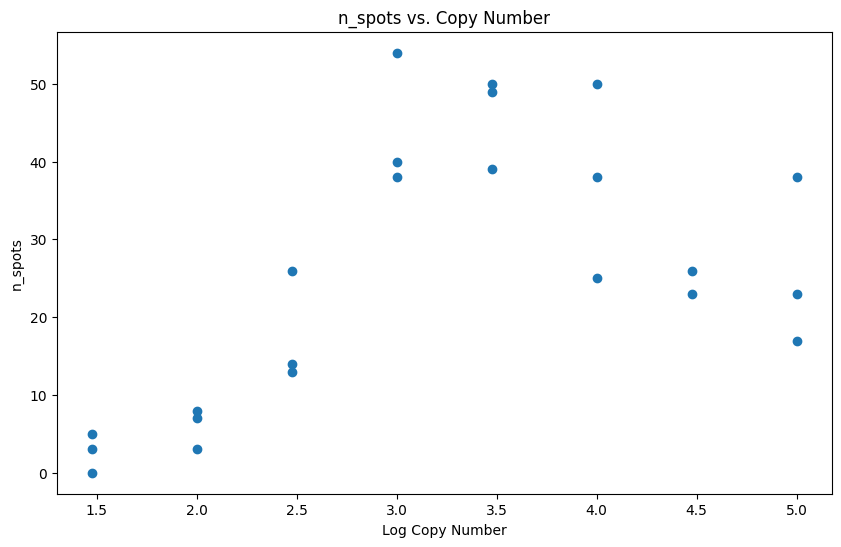

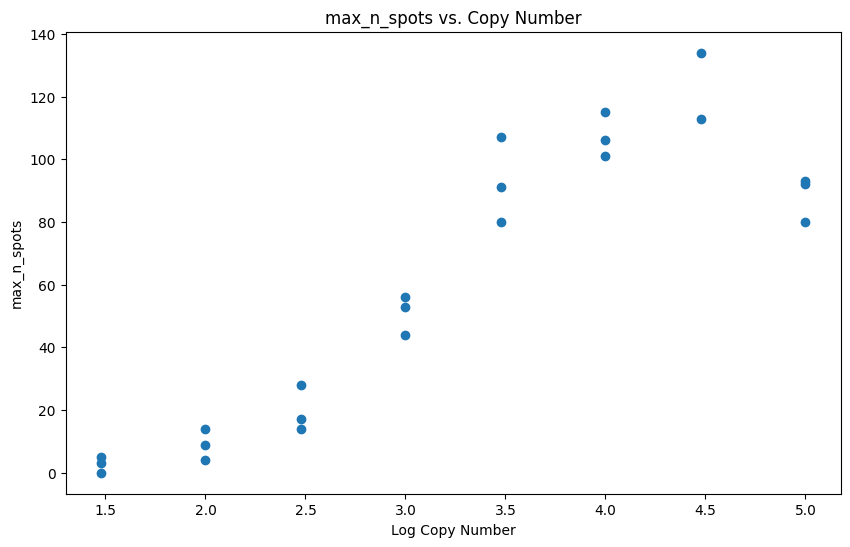

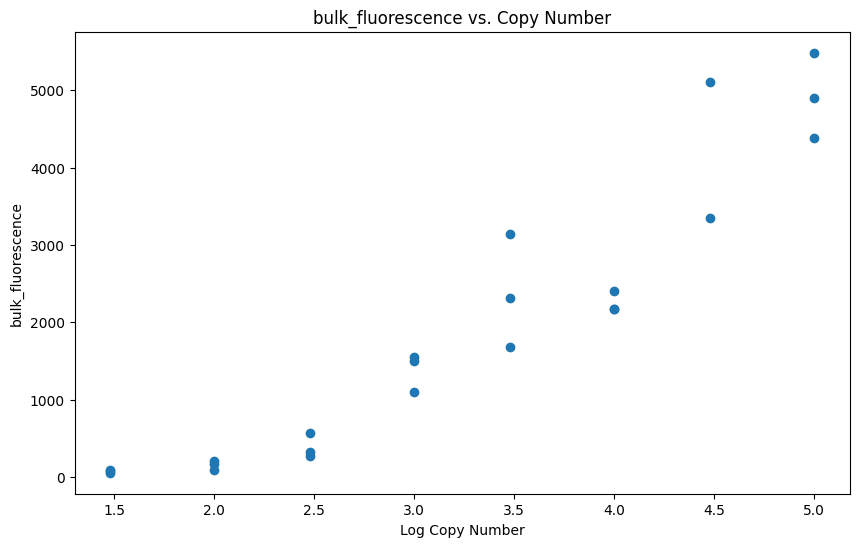

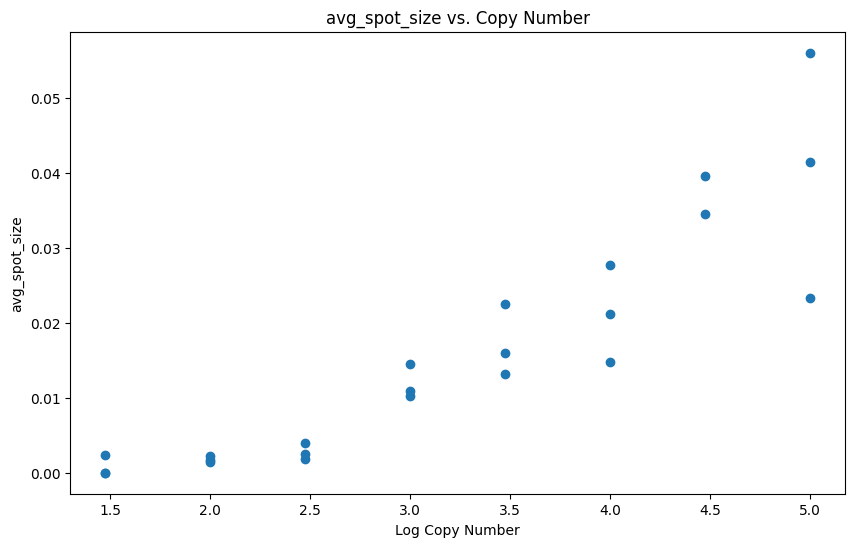

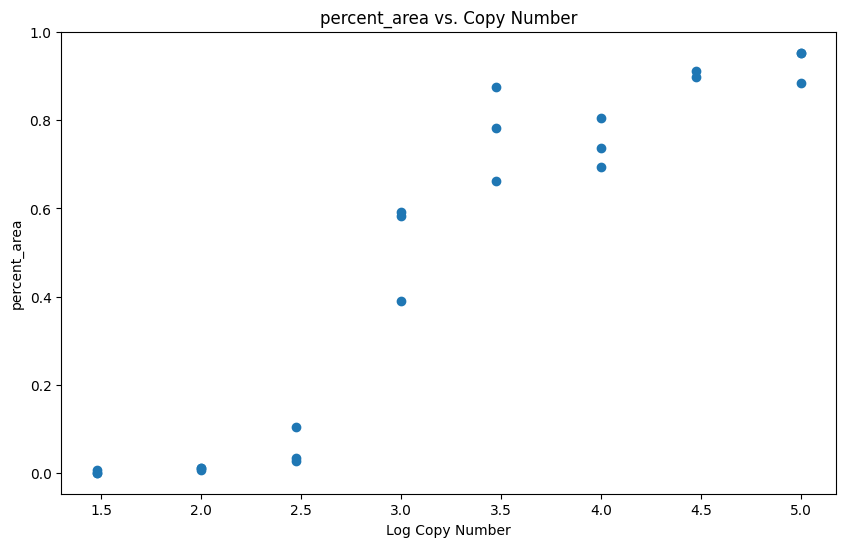

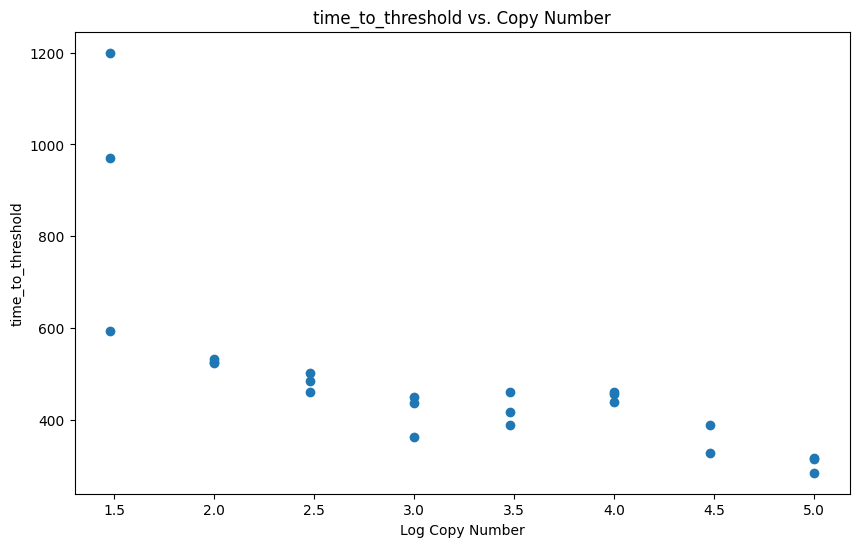

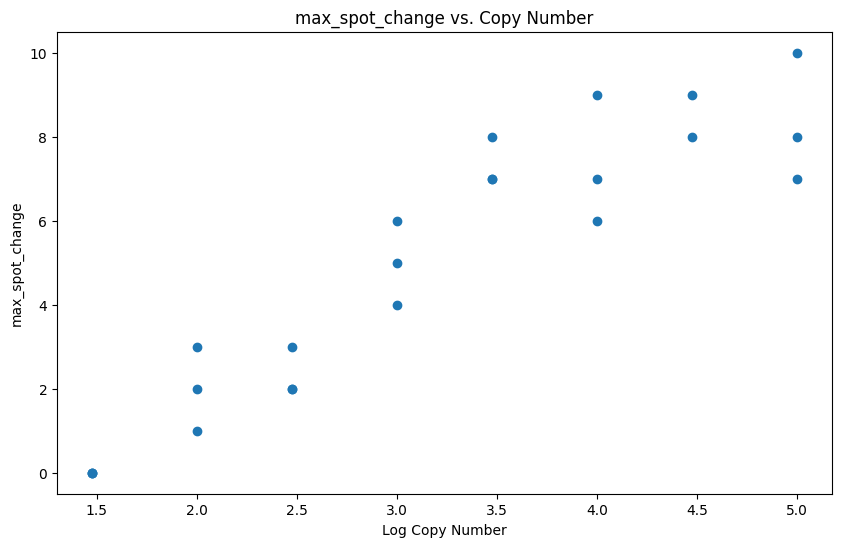

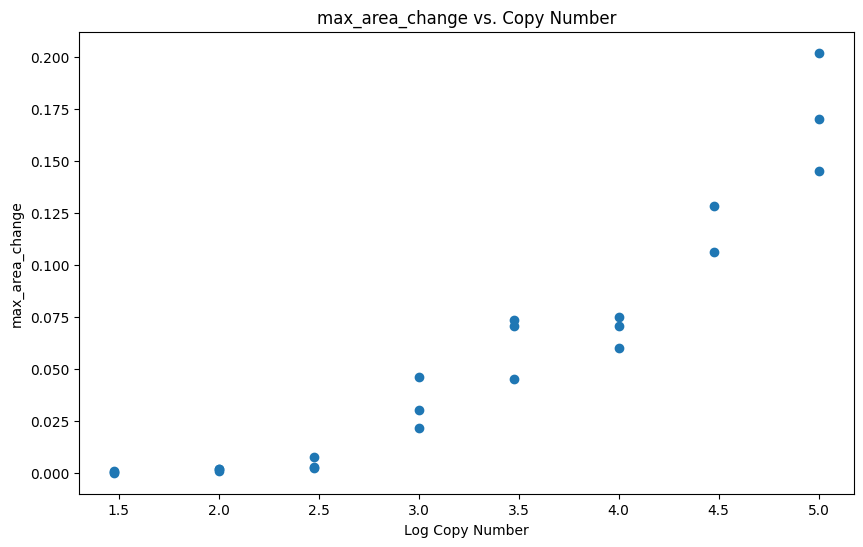

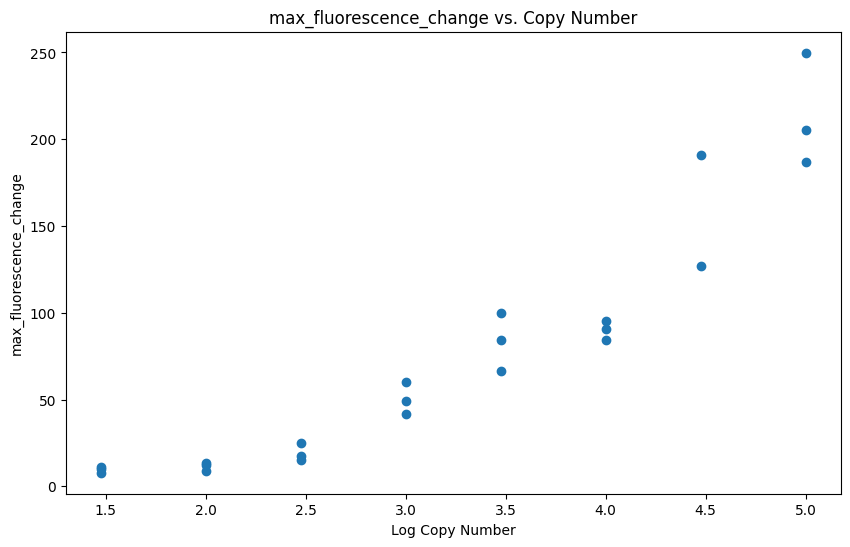

In [7]:
for feature in df.columns:
  if feature not in {"copy_number", "log_copy_number"}:
    plot_feature_vs_log_copy_number(df, feature)

## Models

In [8]:
X = df.drop(['copy_number', 'log_copy_number', 'time_to_threshold'], axis=1)
y = df['log_copy_number'].values

In [9]:
#@title custom train test split
def custom_train_test_split(X, y, random_state=None):
  # Combine X and y for shuffling while keeping corresponding labels intact
  combined_data = np.column_stack((X, y))

  unique_labels = np.unique(y)
  test_indices = []

  np.random.seed(random_state)

  for label in unique_labels:
    label_indices = np.where(y == label)[0]
    test_index = np.random.choice(label_indices, size=1, replace=False)
    test_indices.extend(test_index)

  test_mask = np.zeros(len(X), dtype=bool)
  test_mask[test_indices] = True

  X_train, X_test = X[~test_mask], X[test_mask]
  y_train, y_test = y[~test_mask], y[test_mask]

  return X_train, X_test, y_train, y_test

### Single linear regression model

In [10]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_train, X_test, y_train, y_test = custom_train_test_split(X, y)

In [11]:
# Train Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict
linear_pred = linear_model.predict(X_test)

# Calculate evaluation metrics
linear_mse = mean_squared_error(y_test, linear_pred)
linear_mae = mean_absolute_error(y_test, linear_pred)

# Print evaluation metrics
print(f"Linear Regression MSE: {linear_mse}")
print(f"Linear Regression MAE: {linear_mae}")

Linear Regression MSE: 0.06594349844531118
Linear Regression MAE: 0.21891045976823195


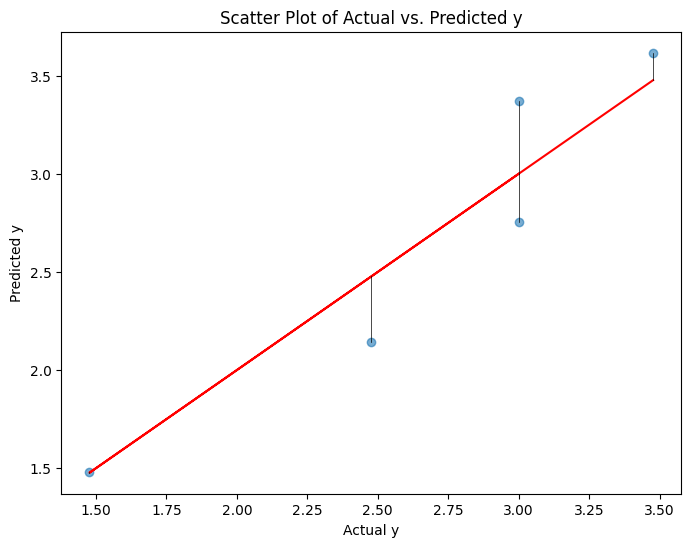

In [12]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, linear_pred, alpha=0.6)
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs. Predicted y')

# Add a reference line (y = x)
plt.plot(y_test, y_test, color='red')

# Draw vertical lines to visualize error
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], linear_pred[i]], color='black', linestyle='-', linewidth=0.5)

plt.show()

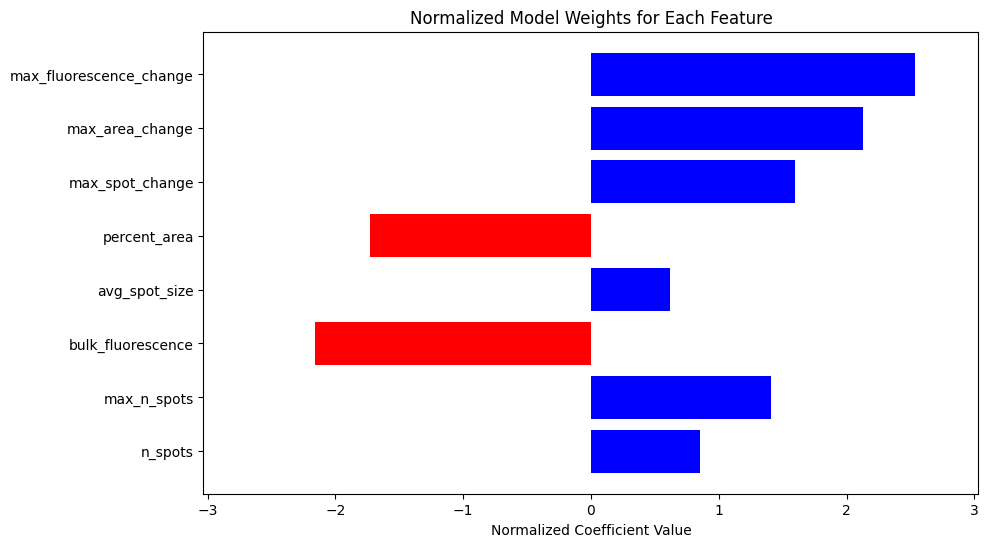

In [13]:
# Get feature names
feature_names = X.columns

# Get coefficients (weights) from the linear model
coefficients = linear_model.coef_

# Calculate the range of each feature
feature_ranges = X.max() - X.min()

# Normalize coefficients by feature ranges
normalized_coefficients = coefficients * feature_ranges

# Create a bar chart for normalized model weights
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(feature_names)), normalized_coefficients, color=['red' if c < 0 else 'blue' for c in normalized_coefficients])
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Normalized Coefficient Value')
plt.title('Normalized Model Weights for Each Feature')

highest_weight = max([abs(c) for c in normalized_coefficients])
plt.xlim([-highest_weight-0.5, highest_weight+0.5])

plt.show()

### linear regression model weights w/ 100 train-test splits

In [14]:
# Initialize a DataFrame to store the coefficients from each trial
coefficients_df = pd.DataFrame(columns=feature_names)

for trial in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # X_train, X_test, y_train, y_test = custom_train_test_split(X, y)
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    # Normalize coefficients
    normalized_coefficients = linear_model.coef_ * (X.max() - X.min())
    coefficients_df.loc[trial] = normalized_coefficients

coefficients_df.head()

,n_spots,max_n_spots,bulk_fluorescence,avg_spot_size,percent_area,max_spot_change,max_area_change,max_fluorescence_change
0,1.253490,3.887217,-0.125274,-0.977502,-5.142381,1.363628,5.799361,0.152175
1,0.939635,2.334357,-2.903053,0.358590,-2.832064,1.846607,1.665471,4.195414
2,0.994275,2.442838,-1.468615,0.351019,-2.712731,1.124315,2.832553,1.952647
3,0.691860,1.282364,-4.688679,1.317352,-1.168153,1.150521,0.567395,6.413586
4,0.873502,0.746811,-4.360570,2.313964,-1.378067,1.531841,0.804903,5.306212


In [15]:
# Calculate mean and standard deviation
mean_coefficients = coefficients_df.mean()
std_coefficients = coefficients_df.std()

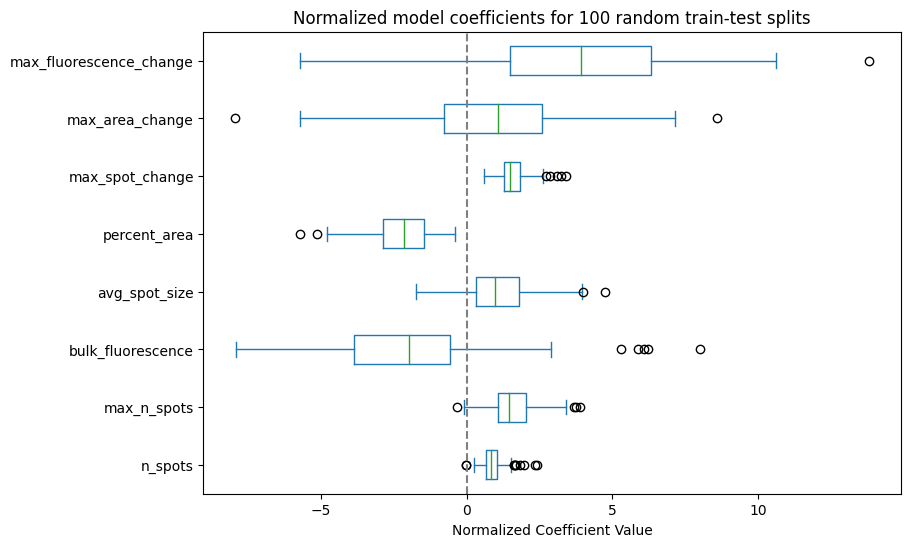

In [16]:
coefficients_df.plot.box(vert=False, figsize=(9, 6))
plt.axvline(x=0, color='grey', linestyle='--')
plt.title('Normalized model coefficients for 100 random train-test splits')
plt.xlabel('Normalized Coefficient Value')
plt.show()

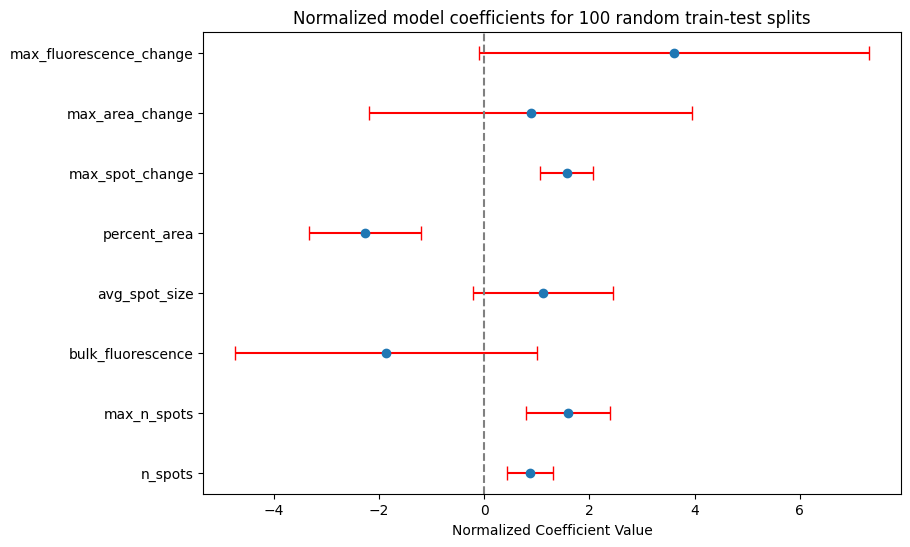

In [17]:
plt.figure(figsize=(9, 6))
plt.errorbar(mean_coefficients, mean_coefficients.index, xerr=std_coefficients, fmt='o', ecolor='r', capsize=5, linestyle='None')
plt.axvline(x=0, color='grey', linestyle='--')
plt.title('Normalized model coefficients for 100 random train-test splits')
plt.xlabel('Normalized Coefficient Value')
plt.show()

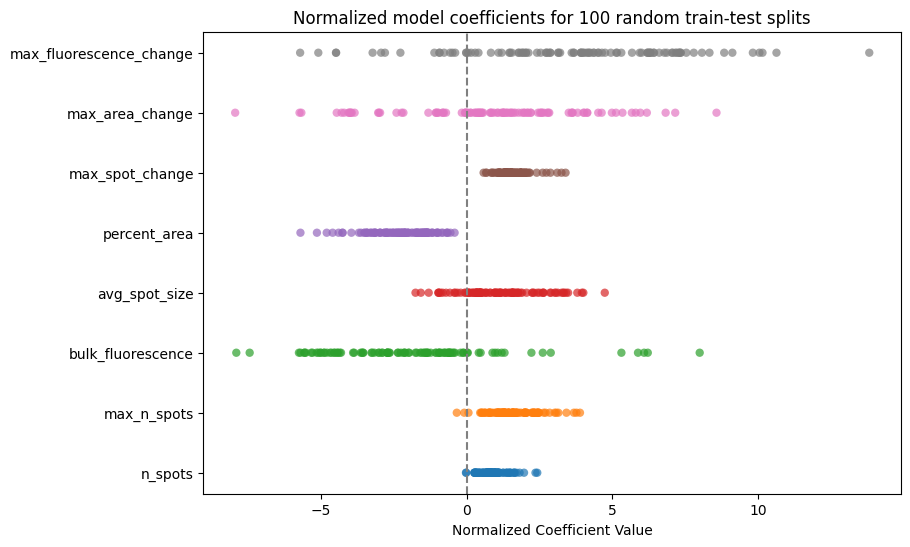

In [18]:
plt.figure(figsize=(9, 6))
for feature in feature_names:
    plt.scatter(coefficients_df[feature], [feature] * 100, alpha=0.7, edgecolors='none')

plt.axvline(x=0, color='grey', linestyle='--')
plt.title('Normalized model coefficients for 100 random train-test splits')
plt.xlabel('Normalized Coefficient Value')
plt.show()

### regression model performance w/ 100 train-test splits

In [19]:
#@title run regression models
def run_regression_model(X, y, model):

  ### run models

  predictions_dict = defaultdict(list)
  train_mse = []
  test_mse = []

  for trial in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    train_pred = model.predict(X_train)

    for pred, actual in zip(y_pred, y_test):
      predictions_dict[actual].append(pred)

    train_mse.append(mean_squared_error(y_train, train_pred))
    test_mse.append(mean_squared_error(y_test, y_pred))

  predictions_df = pd.DataFrame.from_dict(predictions_dict, orient='index').transpose()
  avg_train_mse = np.mean(train_mse)
  avg_test_mse = np.mean(test_mse)

  return avg_train_mse, avg_test_mse, predictions_df

def plot_model_predictions(X, y, model):
  avg_train_mse, avg_test_mse, predictions_df = run_regression_model(X, y, model)
  regression_model_name = model.__class__.__name__

  print(f'average train MSE: {avg_train_mse}')
  print(f'average test MSE: {avg_test_mse}')

  # error bar graph of predicted vs actual
  # plt.figure(figsize=(10, 10))

  # means = []
  # stds = []

  # for y in predictions_df.columns:
  #   vals = [val for val in predictions_df[y] if str(val) != "nan"]
  #   means.append(np.mean(vals))
  #   stds.append(np.std(vals))


  # plt.errorbar(predictions_df.columns, means, yerr=stds, fmt='o', ecolor='r',
  #             capsize=5, linestyle='None', label="mean & standard deviation of predicted values")

  # plt.plot([1, 5], [1, 5], color='red', linestyle='--')

  # plt.xlabel('Actual')
  # plt.ylabel('Predicted')
  # plt.title(f'Predicted vs Actual log copy # for {regression_model_name} models for 100 train-test splits')
  # plt.legend()
  # plt.show()
  plot_model_errors([predictions_df], [f'{regression_model_name} for 100 train-test splits'])

  # Scatter plot of predicted vs actual
  # plt.figure(figsize=(10, 10))

  # for y in predictions_df.columns:
  #   vals = [val for val in predictions_df[y] if str(val) != "nan"]
  #   plt.scatter([y] * len(vals), vals, alpha=0.5, color="cornflowerblue")

  # plt.plot([1, 5], [1, 5], color='red', linestyle='--')

  # plt.xlabel('Actual')
  # plt.ylabel('Predicted')
  # plt.title(f'Predicted vs Actual log copy # for {regression_model_name} models for 100 train-test splits')
  # # plt.gca().set_aspect('equal', adjustable='box')
  # plt.show()

def plot_model_errors(predictions_dfs, model_names):
  # error bar graph of predicted vs actual
  plt.figure(figsize=(10, 10))

  for predictions_df, model_name in zip(predictions_dfs, model_names):
    means = []
    stds = []

    for y in predictions_df.columns:
      vals = [val for val in predictions_df[y] if str(val) != "nan"]
      means.append(np.mean(vals))
      stds.append(np.std(vals))


    plt.errorbar(predictions_df.columns, means, yerr=stds, fmt='o',
                capsize=5, linestyle='None', label=model_name)

  plt.plot([1, 5], [1, 5], color='red', linestyle='--')

  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title(f'Predicted vs Actual log copy #')
  plt.legend()
  plt.show()

average train MSE: 0.01734734982898702
average test MSE: 0.1204034635814023


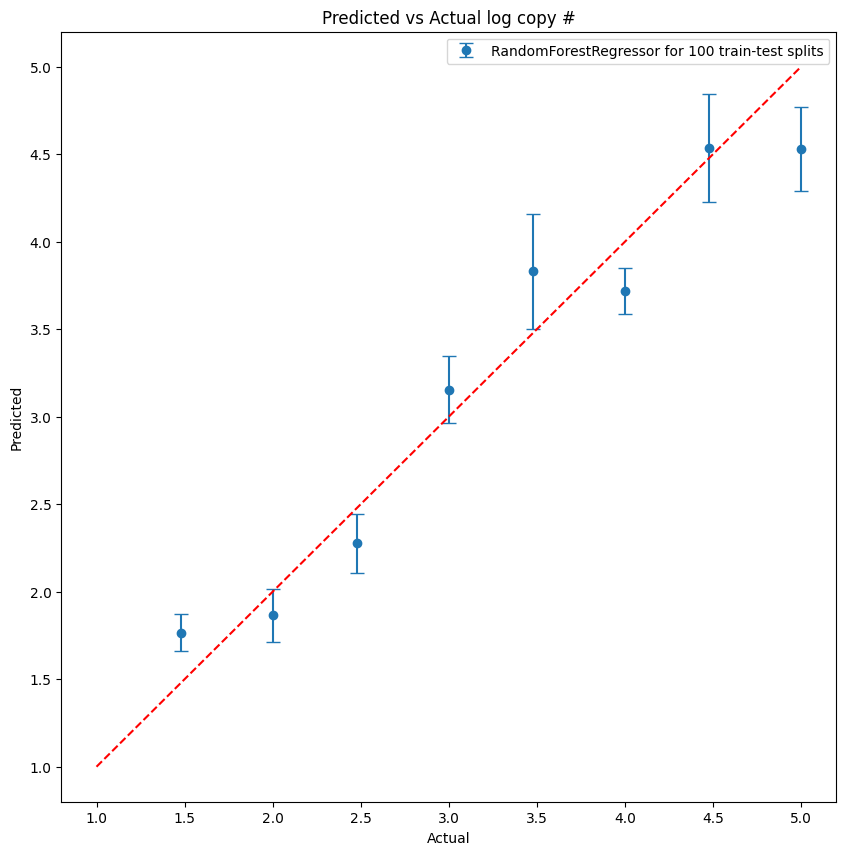

In [20]:
plot_model_predictions(X, y, RandomForestRegressor())

average train MSE: 0.027971078633003778
average test MSE: 0.29331172997279753


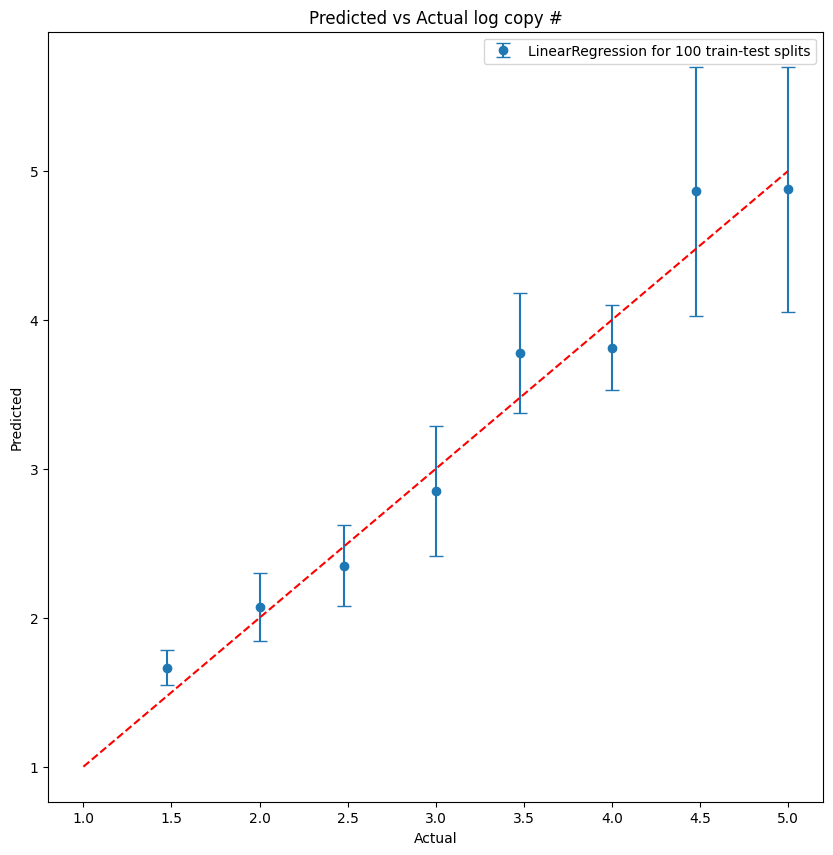

In [21]:
plot_model_predictions(X, y, LinearRegression())

average train MSE: 0.0
average test MSE: 0.26013828811306466


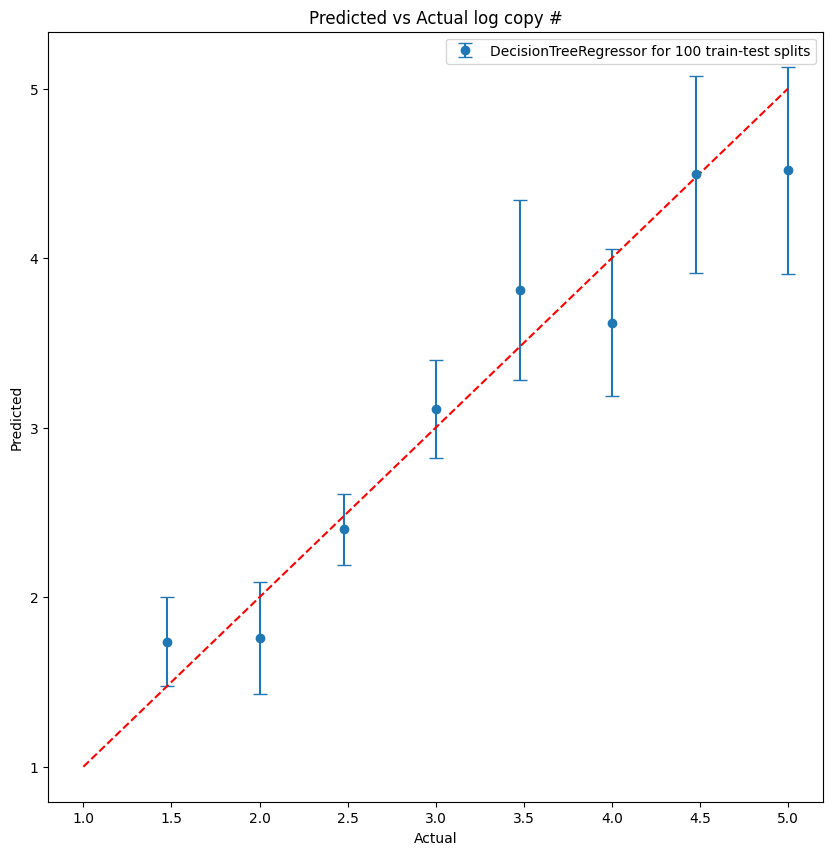

In [22]:
plot_model_predictions(X, y, DecisionTreeRegressor())

## Comparison w/ Ben's spot counts

In [23]:
bens_spot_counts = {
    30: [1, 3, 5],
    100: [6, 7, 4],
    300: [11, 25, 16],
    1000: [50, 47, 34],
    3000: [53, 104, 69],
    10000: [76, 81, 105],
    30000: [30, 89],
    100000: [17, 5, 25]
}

In [24]:
# Constants for the power-law relationship
b = 0.184
m = 0.766

# Function to predict copy numbers from spot counts
def predict_copy_numbers(spot_counts):
    return (spot_counts / b) ** (1 / m)

# Convert spot counts to predicted copy numbers
predicted_copy_numbers = {key: predict_copy_numbers(np.array(val)) for key, val in bens_spot_counts.items()}

# Take the log base 10 of real and predicted copy numbers
log_real_copy_numbers = np.log10(list(bens_spot_counts.keys()))
log_predicted_copy_numbers = np.log10([item for sublist in predicted_copy_numbers.values() for item in sublist])

# Create a DataFrame of spot predictions
max_predictions = max(len(val) for val in predicted_copy_numbers.values())

data = {}
for i in range(max_predictions):
    for j, key in enumerate(log_real_copy_numbers):
        if i < len(predicted_copy_numbers[list(bens_spot_counts.keys())[j]]):
            if key not in data:
                data[key] = [np.nan] * max_predictions
            data[key][i] = np.log10(predicted_copy_numbers[list(bens_spot_counts.keys())[j]][i])

all_log_copy_numbers = []
all_log_predicted_copy_numbers = []
for real in predicted_copy_numbers:
  for pred in predicted_copy_numbers[real]:
    all_log_copy_numbers.append(np.log10(real))
    all_log_predicted_copy_numbers.append(np.log10(pred))

# Calculate Mean Squared Error (MSE) on predicted log copy numbers
mse_log_copy_numbers = mean_squared_error(all_log_copy_numbers, all_log_predicted_copy_numbers)
print("Mean Squared Error on Predicted Log Copy Numbers:", mse_log_copy_numbers)

all_log_copy_numbers = []
all_log_predicted_copy_numbers = []
for real in predicted_copy_numbers:
  for pred in predicted_copy_numbers[real]:
    if real > 3000:
      continue
    all_log_copy_numbers.append(np.log10(real))
    all_log_predicted_copy_numbers.append(np.log10(pred))

# Calculate Mean Squared Error (MSE) on predicted log copy numbers
mse_log_copy_numbers = mean_squared_error(all_log_copy_numbers, all_log_predicted_copy_numbers)
print("Mean Squared Error on Predicted Log Copy Numbers < 10000:", mse_log_copy_numbers)

spot_predictions_df = pd.DataFrame(data)
spot_predictions_df

Mean Squared Error on Predicted Log Copy Numbers: 1.115968058861452
Mean Squared Error on Predicted Log Copy Numbers < 10000: 0.051885318583131994


,1.477121,2.000000,2.477121,3.000000,3.477121,4.000000,4.477121,5.000000
0,0.959768,1.975631,2.319288,3.177744,3.210781,3.415138,2.888125,2.566098
1,1.582642,2.063029,2.784755,3.142663,3.592971,3.451263,3.504663,1.872261
2,1.872261,1.745747,2.531726,2.959088,3.360354,3.598396,NaN,2.784755


In [25]:
_, test_mse, random_forest_predictions_df = run_regression_model(X, y, RandomForestRegressor())
print(f"Random Forest Test MSE: {test_mse}")

Random Forest Test MSE: 0.11910589380718607


In [31]:
points, counts = [1,20,40,80,200,3000,10000,30000], [6, 2, 45, 4, 67, 126, 95, 125]

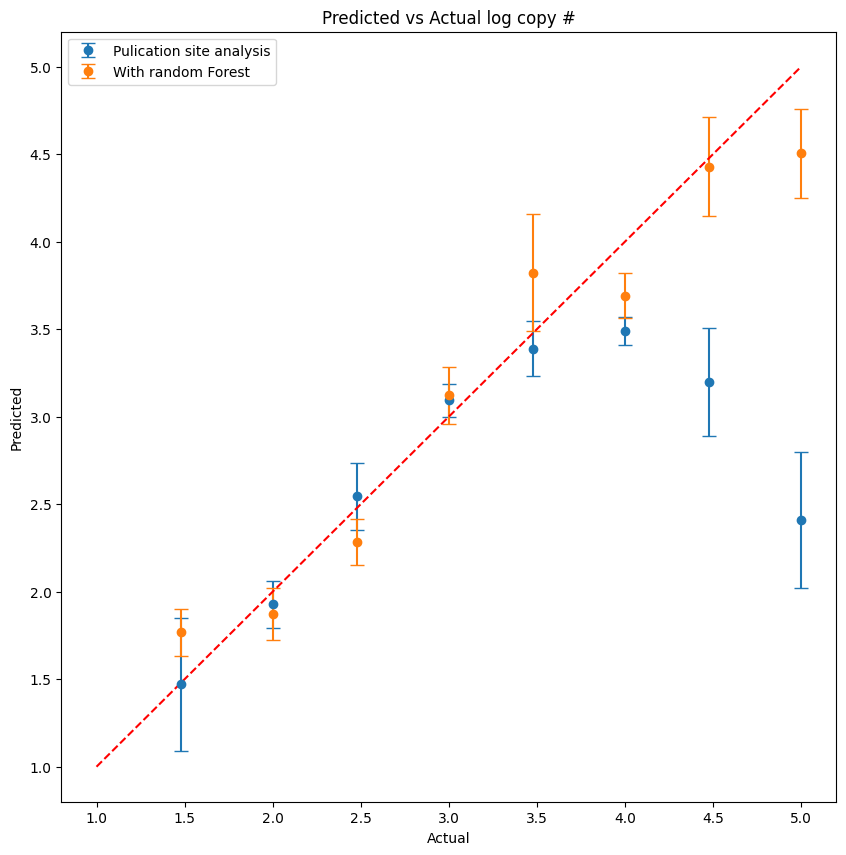

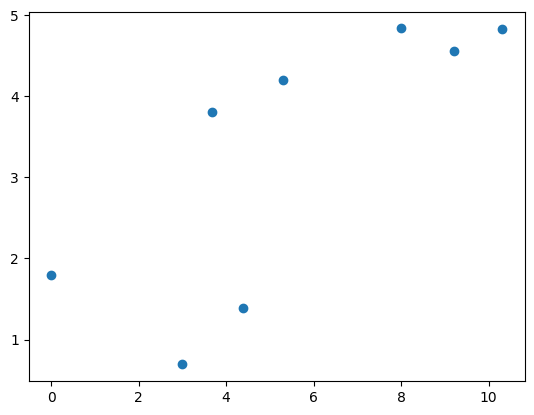

In [33]:
plot_model_errors([spot_predictions_df, random_forest_predictions_df], ["Pulication site analysis", "With random Forest"])
plt.scatter( np.log(points), np.log(counts))

In [27]:
X_3000 = df[df.log_copy_number < 3.5].drop(['copy_number', 'log_copy_number', 'time_to_threshold'], axis=1)
y_3000 = df[df.log_copy_number < 3.5]['log_copy_number'].values

In [28]:
_, test_mse, random_forest_predictions_df_3000 = run_regression_model(X_3000, y_3000, RandomForestRegressor())
print(f"Random Forest Test MSE < 10000: {test_mse}")

Random Forest Test MSE < 10000: 0.05380620608226803


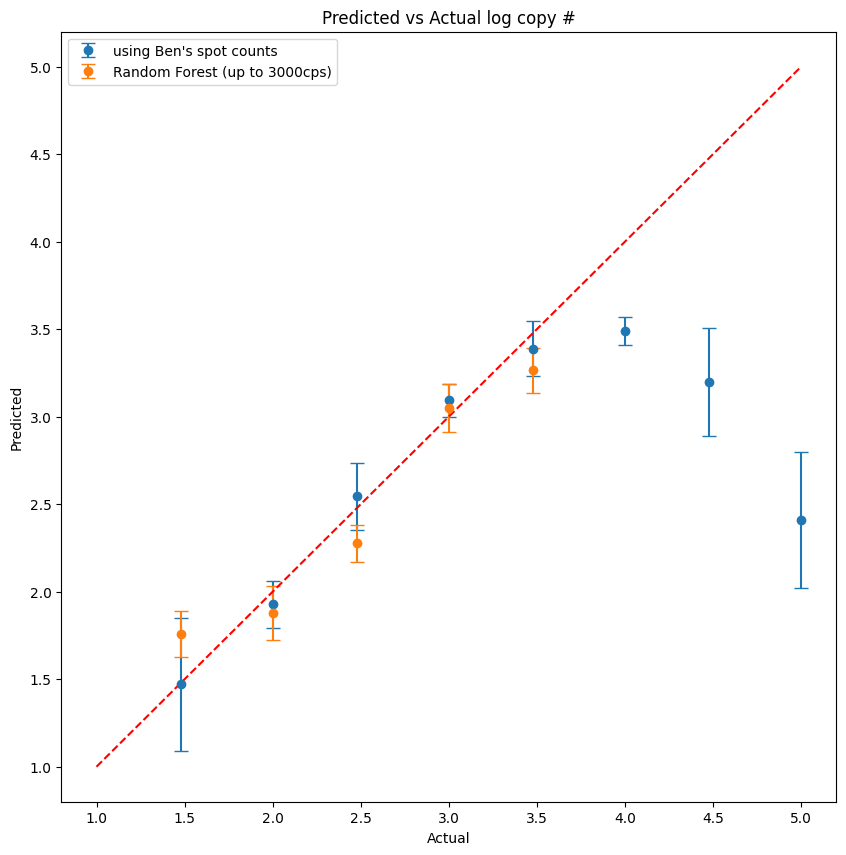

In [29]:
plot_model_errors([spot_predictions_df, random_forest_predictions_df_3000], ["using Ben's spot counts", "Random Forest (up to 3000cps)"])